# 1. Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import reverse_geocoder as rg
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df_housing = fetch_california_housing(as_frame=True)['frame']
df_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
df_score = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'R2_train', 'R2_test', 'attributes'])

# 2. Работа с пропусками

In [ ]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
0 in df_housing.values

False

Пропусков и нулевых значений в датафрейме нет.

# 3. Разделение выборки на train и test

In [ ]:
X = df_housing.drop(['MedHouseVal'], axis=1)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y = df_housing['MedHouseVal']
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Обучение модели линейной регрессии

In [ ]:
def get_predicts(X_train, X_test, y_train):
  model = LinearRegression()
  model.fit(X_train, y_train)

  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  return y_pred_train, y_pred_test

In [ ]:
def get_score(df_score, values, model_info, attributes_info):
  score = {}
  for k, v in values.items():
    score[f'RMSE_{k}'] = mean_squared_error(v[0], v[1], squared=False)
    score[f'R2_{k}'] = r2_score(v[0], v[1])

  for k, v in score.items():
      print(f'{k} = {v}')

  score['model'] = model_info
  score['attributes'] = attributes_info

  return score

In [ ]:
y_pred_train, y_pred_test = get_predicts(X_train, X_test, y_train)

In [ ]:
score = get_score(df_score, {'train': [y_train, y_pred_train], 'test': [y_test, y_pred_test]},
                  'LR (без изменений)', '-')

df_score.loc[len(df_score)] = score

RMSE_train = 0.7196757085831575
R2_train = 0.6125511913966952
RMSE_test = 0.7455813830127764
R2_test = 0.5757877060324508


# 5. График распределения MedHouseVal

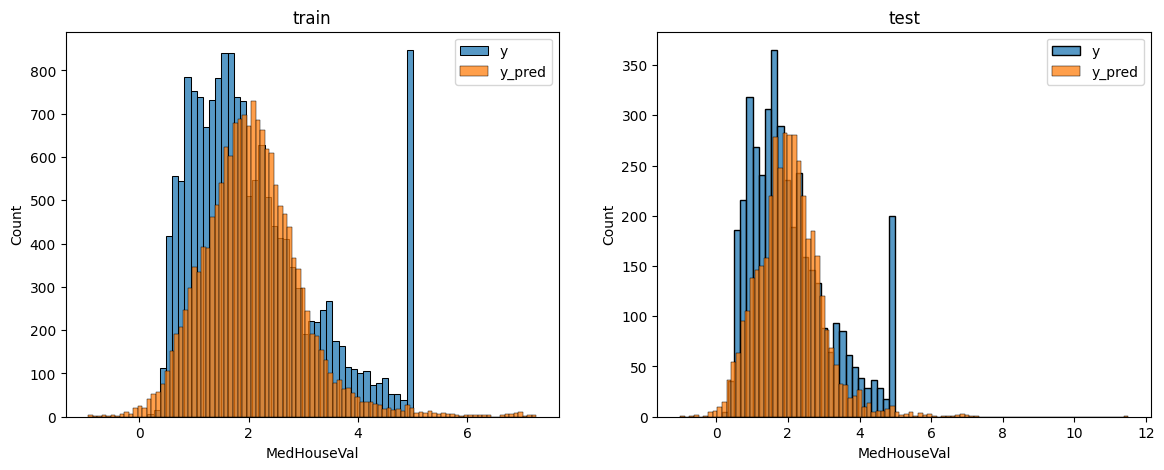

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(y_train, ax=ax[0], label='y')
sns.histplot(y_pred_train, ax=ax[0], label='y_pred').set_title('train')
sns.histplot(y_test, ax=ax[1], label='y')
sns.histplot(y_pred_test, ax=ax[1], label='y_pred').set_title('test')

ax[0].legend(['y', 'y_pred'])
ax[1].legend(['y', 'y_pred'])
plt.show()

Гистограммы для предсказанных и реальных значений отличаются.

Распределение предсказанных значений (как для тестовой, так и для обучающей выборок) скорее стремится к нормальному. Есть небольшой сдвиг вправо пика значений.

Реальные значения как будто имеют выбросы в значении, близком к 5.

# 6. Корреляционная матрица

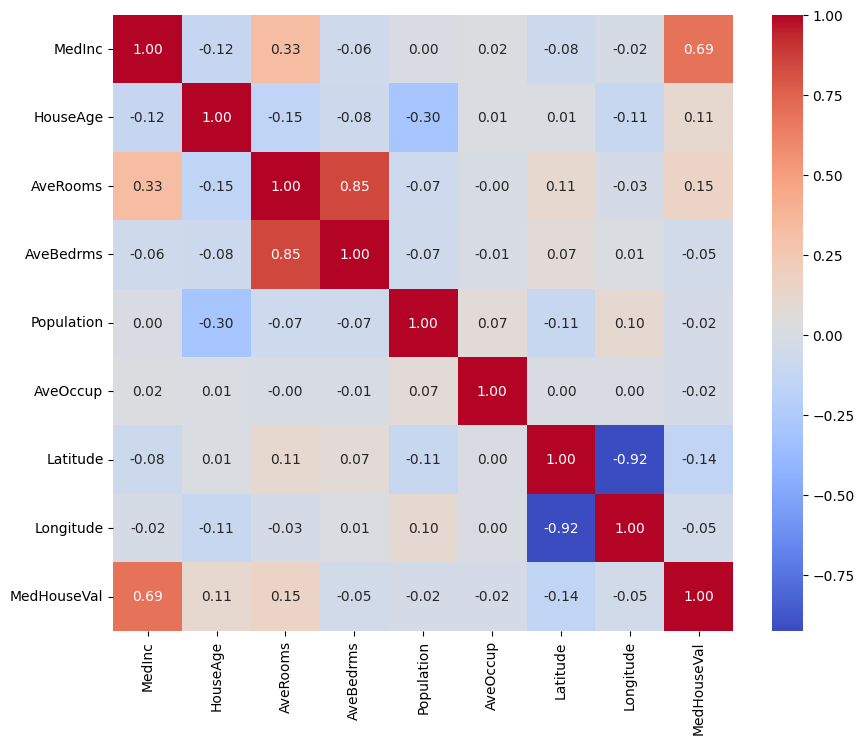

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df_housing.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

Согласно матрице корреляции единственный признак, который достаточно сильно влияет на значение MedHouseVal, - это MedInc.

В качестве эксперимента можно оставить только его.

In [ ]:
X = df_housing[['MedInc']]
y = df_housing['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred_train, y_pred_test = get_predicts(X_train, X_test, y_train)

score = get_score(df_score,
                  {'train': [y_train, y_pred_train], 'test': [y_test, y_pred_test]},
                  'LR (после удаления всех признаков, кроме MedInc)',
                  "X = [['MedInc']]")

df_score.loc[len(df_score)] = score

RMSE_train = 0.8361487409655547
R2_train = 0.47699273458205227
RMSE_test = 0.8420901241414455
R2_test = 0.45885918903846656


Значение RMSE увеличилось примерно до 0.84.

А вот значение R2 уменьшилось до 0.48 и 0.46 для обучающей и тестовой выборок, соответственно. Модель в данном случае показывает плохие результаты.

In [ ]:
X = df_housing[['MedInc', 'HouseAge', 'AveRooms', 'Latitude']]
y = df_housing['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred_train, y_pred_test = get_predicts(X_train, X_test, y_train)

score = get_score(df_score,
                  {'train': [y_train, y_pred_train], 'test': [y_test, y_pred_test]},
                  'LR (после удаления менее значимых признаков)',
                  "X = [['MedInc', 'HouseAge', 'AveRooms', 'Latitude']]")

df_score.loc[len(df_score)] = score

RMSE_train = 0.7989089953528047
R2_train = 0.5225419016956813
RMSE_test = 0.8059451277212133
R2_test = 0.5043169272470043


При добавлении других атрибутов, у которых в матрице корреляции значение по модулю > 0.1, R2 становится равным 0.5.

# 7. Анализ выбросов

В данном случае, когда матрица корреляции показывает небольшие значения взаимосвязи между MedHouseVal и остальными признаками, можно попробовать сначала исключить выбросы и только потом отобрать значимые признаки для обучения модели.

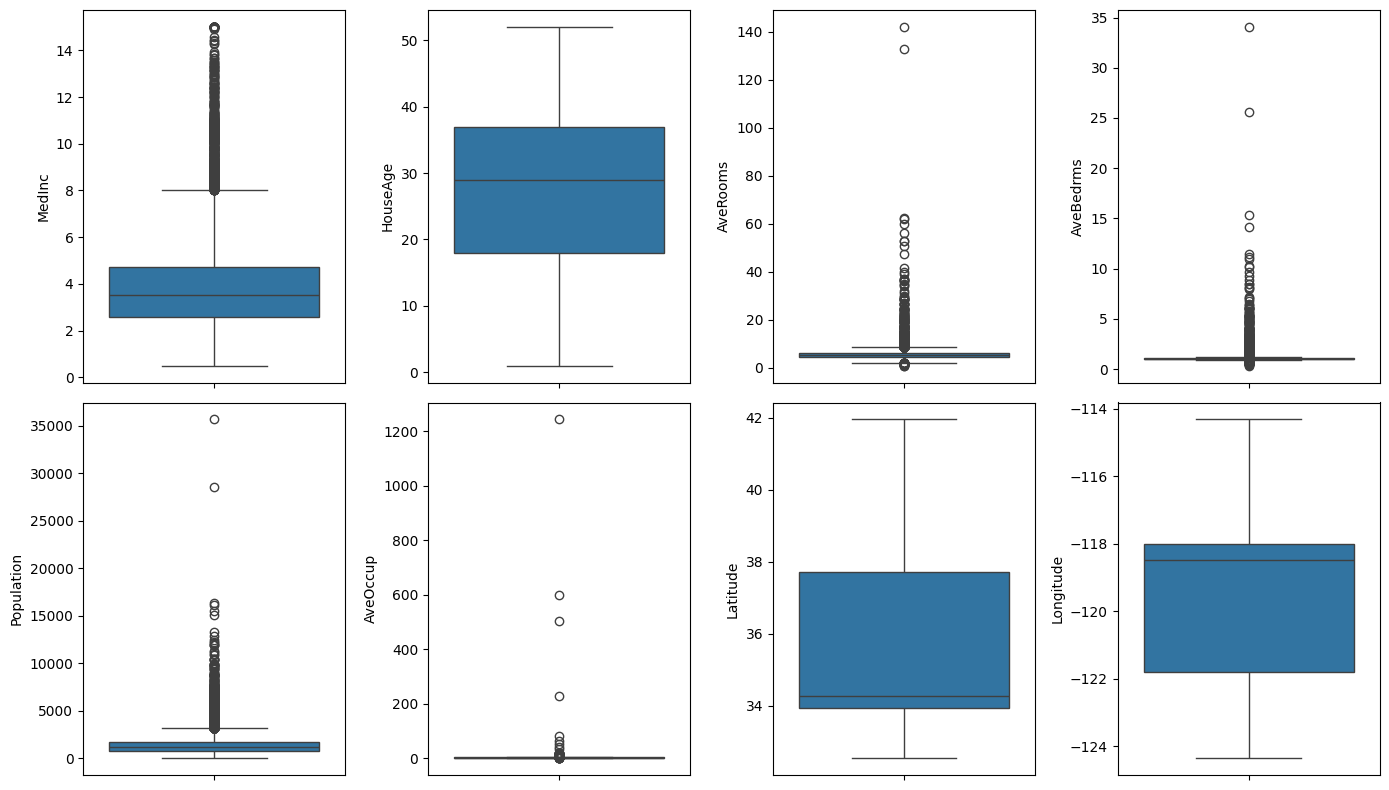

In [ ]:
r, c = 2, 4
fig, ax = plt.subplots(r, c, figsize=(14, 8))

for i, col in zip(range(r*c), df_housing.drop(['MedHouseVal'], axis=1).columns):
  sns.boxplot(df_housing[col], ax=ax[1 if i>=4 else 0][i-4 if i>=4 else i])
  plt.tight_layout()

In [ ]:
def get_upperwhisker(df, column):
  up_q = np.percentile(df[column], 75)
  low_q = np.percentile(df[column], 25)
  diff = up_q - low_q

  up_w = df[col].loc[df[col] <= up_q + 1.5 * diff].max()
  low_w = df[col].loc[df[col] >= low_q - 1.5 * diff].min()

  return up_w, low_w

In [ ]:
print('Выбросы:\n')
for col in df_housing.columns:
  up_w, low_w = get_upperwhisker(df_housing, col)

  outliers = len(df_housing.loc[(df_housing[col] > up_w) | (df_housing[col] < low_w)])
  if outliers > 0:
    print(f'{col} - {round(outliers / len(df_housing) * 100, 3)}%')

Выбросы:

MedInc - 3.299%
AveRooms - 2.476%
AveBedrms - 6.899%
Population - 5.795%
AveOccup - 3.445%
MedHouseVal - 5.189%


Согласно построенным боксплотам в MedInc, AveRooms, AveBedrms, Population, AveOccup имеются выбросы.

Расчет пороговых значений показывает долю выбросов от 2.476% до 6.899% от всех значений в датасете.

Кроме того, в целевой переменной MedHouseVal также имеются выбросы (согласно расчетам и построенной ранее гистрограмме).



In [ ]:
X = df_housing
for col in X.drop(['MedHouseVal'], axis=1):
  up_w, low_w = get_upperwhisker(X, col)
  X = X.loc[(X[col] <= up_w) & (df_housing[col] >= low_w)]

1 - len(X)/len(df_housing)

0.18541666666666667

Удаление всех выбросов (кроме пропусков в целевой переменной) приведет к потере 18,5% данных, что достаточно много.

Можно попробровать удалить выбросы для тех атрибутов, которые минимально влияют на изменение MedHouseVal (согласно матрице корриляции) - AveBedrms, Population и AveOccup.

In [ ]:
columns = ['AveBedrms', 'Population', 'AveOccup']

X = df_housing
for col in columns:
  up_w, low_w = get_upperwhisker(X, col)
  X = X.loc[(X[col] <= up_w) & (X[col] >= low_w)]

In [ ]:
y = X['MedHouseVal']
X = X.drop(['MedHouseVal'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred_train, y_pred_test = get_predicts(X_train, X_test, y_train)

score = get_score(df_score,
                  {'train': [y_train, y_pred_train], 'test': [y_test, y_pred_test]},
                  'LR (после удаления выбросов)',
                  f'{columns} - очищенные от выбросов атрибуты')

df_score.loc[len(df_score)] = score

RMSE_train = 0.6540774294698547
R2_train = 0.6827292445847912
RMSE_test = 0.6618184697363158
R2_test = 0.6838371943621957


RMSE теперь = 0.65 (0.66 для тестовых данных), R2 = 0.68.

# 8. Изменение признаков

In [ ]:
columns = ['AveBedrms', 'Population', 'AveOccup']

X = df_housing
for col in columns:
  up_w, low_w = get_upperwhisker(X, col)
  X = X.loc[(X[col] <= up_w) & (df_housing[col] >= low_w)]

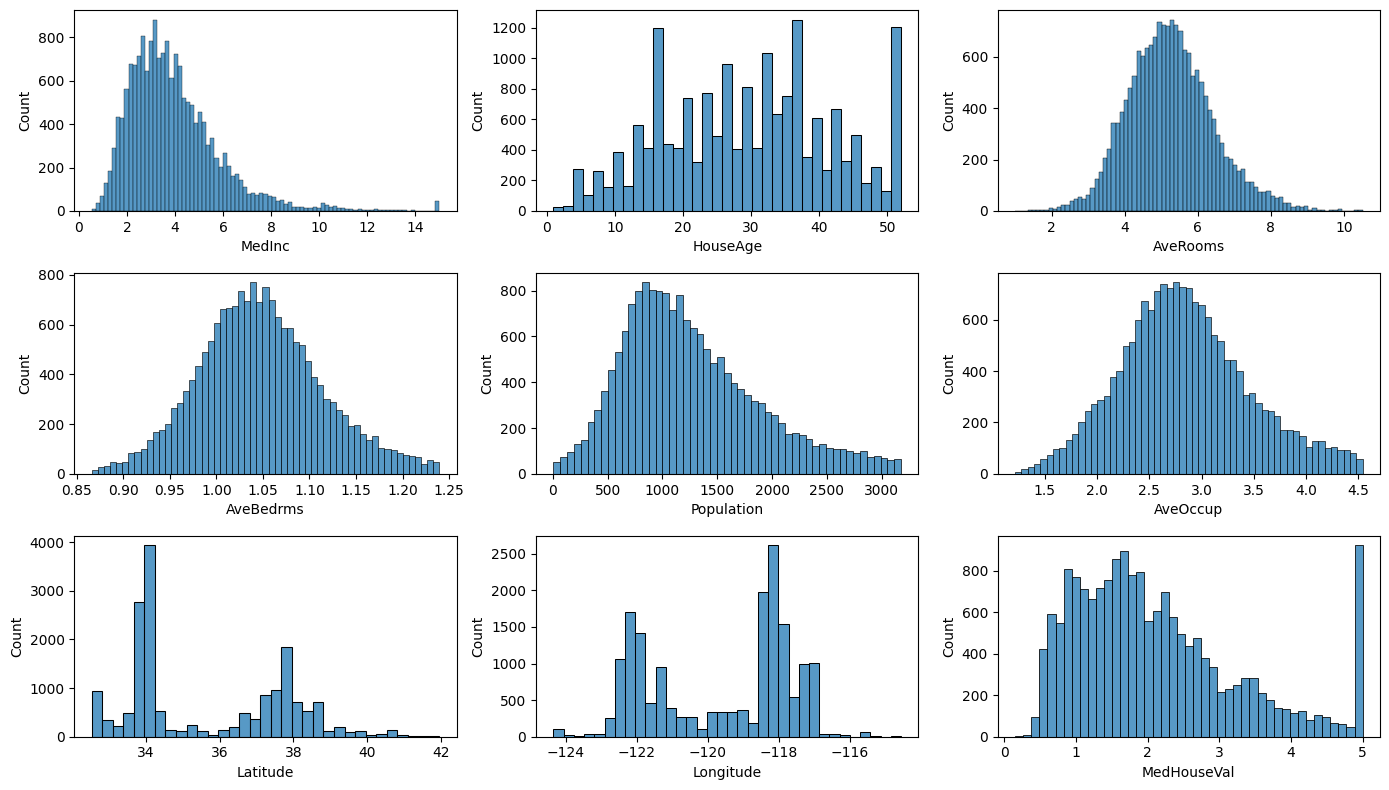

In [ ]:
r, c = 3, 3
fig, ax = plt.subplots(r, c, figsize=(14, 8))

for i, col in zip(range(r*c), X.columns):
  sns.histplot(X[col], ax=ax[math.floor(i/r)][i%r])
  plt.tight_layout()

In [ ]:
!pip install reverse_geocoder

In [ ]:
columns = ['AveBedrms', 'Population', 'AveOccup']

X = df_housing
for col in columns:
  up_w, low_w = get_upperwhisker(X, col)
  X = X.loc[(X[col] <= up_w) & (X[col] >= low_w)]

y = X['MedHouseVal']

X['AveOccup'] = np.log(X['AveOccup'])
X['HouseAge'] = np.sqrt(X['HouseAge'])

res = rg.search(tuple(zip(X['Latitude'], X['Longitude'])))
X['City'] = [i.get('admin2') for i in res]
le = LabelEncoder()
le.fit(X['City'])
X['City'] = le.transform(X['City'])

X['District'] = [i.get('admin2') for i in res]
X = pd.get_dummies(X, columns = ['District'])

X = X.drop(['MedHouseVal'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred_train, y_pred_test = get_predicts(X_train, X_test, y_train)

score = get_score(df_score,
                  {'train': [y_train, y_pred_train], 'test': [y_test, y_pred_test]},
                  'LR (после изменения и дополнения признаков)',
                  'log(AveOccup), sqrt(HouseAge), добавление округа и города с помощью reverse_geocoder')

df_score.loc[len(df_score)] = score

RMSE_train = 0.5893985159995783
R2_train = 0.7423739393952611
RMSE_test = 0.5942726504836661
R2_test = 0.745079654707316


# 9. Выводы

In [ ]:
df_score.head()

,model,RMSE_train,RMSE_test,R2_train,R2_test,attributes
0,LR (без изменений),0.719676,0.745581,0.612551,0.575788,-
1,"LR (после удаления всех признаков, кроме MedInc)",0.836149,0.842090,0.476993,0.458859,X = [['MedInc']]
2,LR (после удаления менее значимых признаков),0.798909,0.805945,0.522542,0.504317,"X = [['MedInc', 'HouseAge', 'AveRooms', 'Latit..."
3,LR (после удаления выбросов),0.654077,0.661818,0.682729,0.683837,"['AveBedrms', 'Population', 'AveOccup'] - очищ..."
4,LR (после изменения и дополнения признаков),0.589399,0.594273,0.742374,0.745080,"log(AveOccup), sqrt(HouseAge), добавление окру..."


**1. Анализ корреляционной матрицы:**

- X = [['MedInc']]

При удалении всех признаков, у которых взаимосвязь с целевой переменная слабая, значение R2 становится < 0.5, а RMSE увеличивается до 0.84. Модель предсказывает плохо и RMSE больше чем RMSE модели без внесения изменений в данные.

- X = [['MedInc', 'HouseAge', 'AveRooms', 'Latitude']]

Добавление других атрибутов, у которых в матрице корреляции значение по модулю > 0.1, немного увеличивает R2 и уменьшает RMSE. Но модель все еще плозо предсказывает значения.

**2. Анализ выбросов:**

Удаление абсолютно всех выбросов приведет к потере 18,5% данных, это достаточно много.

При удалении выбросов из AveBedrms, Population и AveOccup R2 становится равным 0.68, а RMSE - примерно 0.66. Что уже лучше.

**3. Изменение атрибутов:**

Наилучшие результаты принесло изменение атрибутов AveOccup и HouseAge на log(AveOccup) и sqrt(HouseAge).

Плюс для эксперимента добавлено 2 новых атрибута, вычисленные на основании долготы и широты с помощью reverse_geocoder - город и округ.

В итоге R2 = 0.74, а RMSE = 0.59.

В данном случае модель хорошо справляется.